# Machine Learning Security - Capstone Project

### Group 5: Yin Yin Thu, Wiwat Pholsomboon, Wassim Mecheri

# Part 1:  Detecting Data Poisoning and Adversarial Attacks in Machine Learning

### Phase 1: Dataset Selection and Preprocessing

1.	 Select a suitable dataset for your project. It could be a standard dataset like MNIST, CIFAR-10, or one relevant to your domain.
2.	 Implement preprocessing pipeline: Normalization, train-test splits (70-30 


In [1]:
import kagglehub
import numpy as np
import os 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import random
from imblearn.under_sampling import RandomUnderSampler  

RANDOM_STATE = 999
EPSILON_FGSM = 0.02

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Check if MPS is available (for Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")


c:\Users\pwiwa\anaconda3\envs\security\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
def load_data():
    path = kagglehub.dataset_download("hugovallejo/street-view-house-numbers-svhn-dataset-numpy")

    # Data already split in to train-test with 75-25 ratio
    X_test = np.load(os.path.join(path, 'X_test.npy'))
    y_test = np.load(os.path.join(path, 'y_test.npy'))
    X_train = np.load(os.path.join(path, 'X_train.npy'))
    y_train = np.load(os.path.join(path, 'y_train.npy'))
    
    X_combined = np.concatenate([X_train, X_test], axis=3) 
    y_combined = np.concatenate([y_train, y_test])
     
    X_combined = np.transpose(X_combined, (3, 2, 0, 1)).astype(np.float32) 
    return X_combined, y_combined

def rebalance_data(X, y):
    # Reshape the data to 2D for RandomUnderSampler
    X_combined_reshaped = X.reshape(X.shape[0], -1)  # Flatten the images

    # Apply random under sampling
    rus = RandomUnderSampler(random_state=RANDOM_STATE)
    X_res_flat, y_res = rus.fit_resample(X_combined_reshaped, y)

    # Reshape back to original dimensions
    X_res = X_res_flat.reshape(X_res_flat.shape[0], X.shape[1], X.shape[2], X.shape[3])
    return X_res, y_res


X_combined, y_combined = load_data()
X_combined, y_combined = rebalance_data(X_combined, y_combined)


# Split data to 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_STATE)

print("Train and Test Data Shape:")
print("Train data:", X_train.shape, "Label:", y_train.shape)
print("Test data:", X_test.shape, "Label:", y_test.shape)


Train and Test Data Shape:
Train data: (43778, 3, 32, 32) Label: (43778,)
Test data: (18762, 3, 32, 32) Label: (18762,)


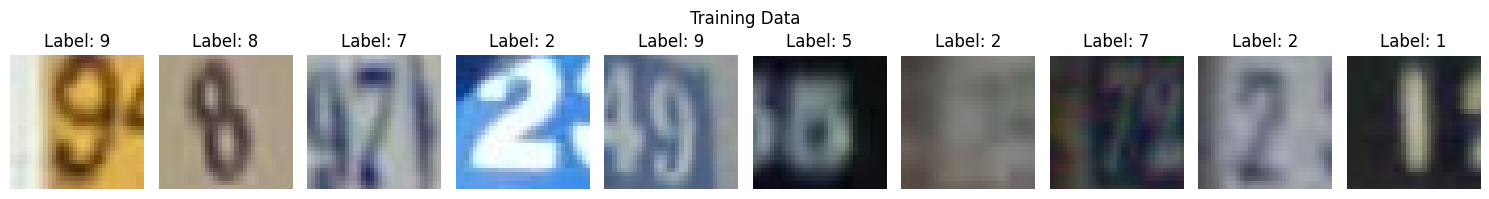

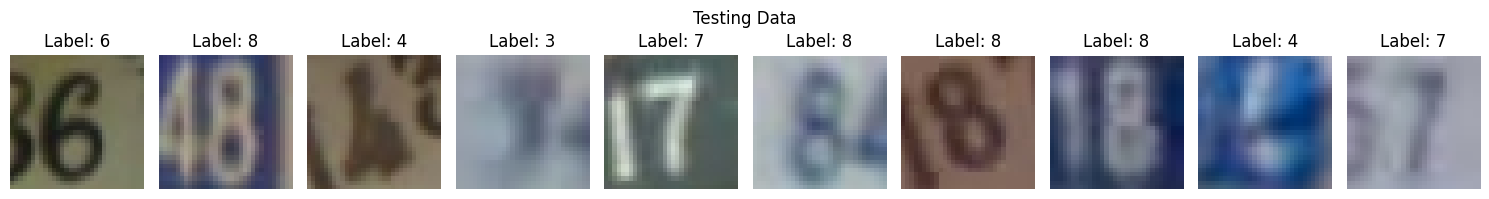

In [3]:
def show_example(X, y, n_samples=10, title=None):
    plt.figure(figsize=(15, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1) 
        plt.imshow(X[i].transpose(1, 2, 0))
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()
        
show_example(X_train, y_train, title="Training Data")
show_example(X_test, y_test, title="Testing Data")


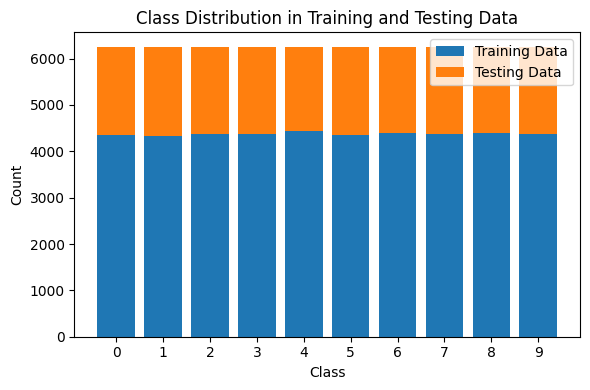

In [4]:
# Count the occurrences of each class
train_class_counts = {}
test_class_counts = {}

# Get unique classes and their counts
for label in range(10):  # CIFAR-10 has 10 classes (0-9)
    train_class_counts[label] = (y_train == label).sum()
    test_class_counts[label] = (y_test == label).sum()

# Get class names from CIFAR-10
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create a figure for the stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))

# Prepare data for stacked bar chart
train_counts = list(train_class_counts.values())
test_counts = list(test_class_counts.values())

# Create the stacked bar chart
ax.bar(class_names, train_counts, label='Training Data')
ax.bar(class_names, test_counts, bottom=train_counts, label='Testing Data')

# Add labels and title
ax.set_title('Class Distribution in Training and Testing Data')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()


### Phase 2: Building a Machine Learning Model
3.	Choose a machine learning model architecture (deep neural network, convolutional neural network…).
4.	Train on clean data with validation-based early stopping
5.	Establish baseline performance metrics (Accuracy and Confusion Matrix)

In [5]:
# Define a CNN model using PyTorch
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x): 
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
 

Reference : https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/8c1214ef4bff586d4a76efbe35e8819cc250733a/examples/get_started_pytorch.py

In [6]:
from art.estimators.classification import PyTorchClassifier

# Define training parameters
learning_rate = 0.001
batch_size = 256
num_epochs = 10

base_model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

base_classifier = PyTorchClassifier(
    model=base_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,    
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device,
)

base_classifier.fit(X_train, y_train, 
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)


Epochs: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


In [8]:
# Evaluate the ART classifier on test examples
base_predition = base_classifier.predict(X_test)
base_accuracy = np.mean(np.argmax(base_predition, axis=1) == y_test)
print("Accuracy on benign test examples: {:.2%}".format(base_accuracy))

Accuracy on benign test examples: 87.85%


### Phase 3: Training-Time Attacks (Data Poisoning)

#### 6.	 Poisoning Attack Implementation
- Inject malicious samples into training data using one of:
- Label-flipping attacks
- Any of the clean-label backdoor attacks
- maintain attack budget (<15% training data contamination)


#### Feature Collision Attacks
- 15% of data is poison

In [19]:
from art.attacks.poisoning import FeatureCollisionAttack

# poison 15% of data
poison_budget = np.int_(0.15 * len(X_train))

# Specify the target sample and layer
target_sample = X_train[0]
print("Target Sample class:", y_train[0]) 
feature_layer = base_classifier.layer_names[-2] 

feature_collision_attack = FeatureCollisionAttack(
    classifier=base_classifier,
    target=target_sample,
    feature_layer=feature_layer,
    learning_rate=0.1,
    max_iter=100
)

poison, poison_labels = feature_collision_attack.poison(X_train[:poison_budget])

Target Sample class: 9


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 1, 32, 32] to have 3 channels, but got 1 channels instead

#### Poisoning Backdoor Attack
- 15% of data is poison

reference: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/8c1214ef4bff586d4a76efbe35e8819cc250733a/notebooks/poisoning_attack_clean_label_backdoor.ipynb

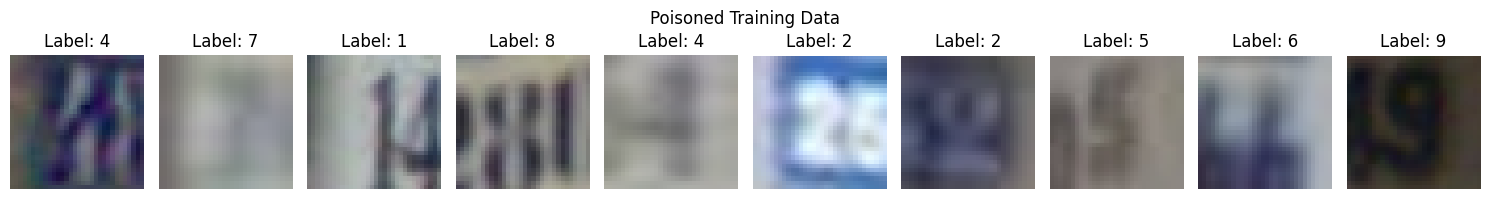

In [ ]:
# from art.attacks.poisoning import PoisoningAttackBackdoor
# from art.attacks.poisoning.perturbations import add_pattern_bd

# # poison 15% of data
# poison_budget = np.int_(0.15 * len(X_train))

# # poison 15% of data
# backdoor = PoisoningAttackBackdoor(lambda x: add_pattern_bd(x, distance=2, pixel_value=1, channels_first=True))
# X_poisoned, y_poisoned = backdoor.poison(X_train[:poison_budget], np.full(poison_budget, 0).astype(np.int32))

# # Combine poisoned data with clean data
# X_train_poisoned = np.concatenate([X_poisoned, X_train[poison_budget:]], axis=0)
# y_train_poisoned = np.concatenate([y_poisoned, y_train[poison_budget:]], axis=0)

# show_example(X_train_poisoned[::-10], y_train_poisoned[::-10], title="Poisoned Training Data")

#### 7.	Poisoned Model Evaluation
- Retrain model on contaminated dataset
- Compare performance degradation on:
   - Clean test set
   - Poisoned validation samples
   - Original validation set


In [9]:
poisoned_classifier = base_classifier.clone_for_refitting()

poisoned_classifier.fit(X_train_poisoned, y_train_poisoned, 
                        batch_size=batch_size, 
                        nb_epochs=num_epochs,
                        verbose=True)

Epochs: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


In [10]:
# Evaluate the ART classifier on test examples
poisoned_prediction = poisoned_classifier.predict(X_test)
poisoned_accuracy = np.mean(np.argmax(poisoned_prediction, axis=1) == y_test)
print("Accuracy on backdoor test examples: {}%".format(poisoned_accuracy * 100))

Accuracy on backdoor test examples: 88.31681057456561%


Accuracy on backdoor poisoned test examples: 98.88071634154142%


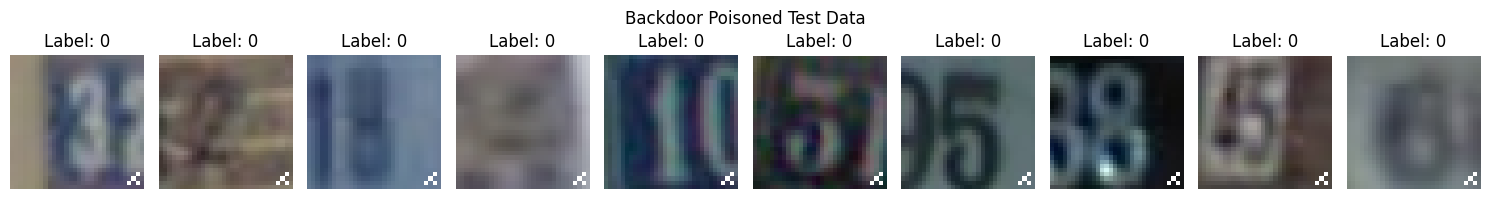

In [11]:
X_test_poisoned, y_test_poisoned = backdoor.poison(X_test, np.full(X_test.shape[0], 0).astype(np.int32))
backdoor_poison_prediction = poisoned_classifier.predict(X_test_poisoned)
backdoor_poison_accuracy = np.mean(np.argmax(backdoor_poison_prediction, axis=1) == y_test_poisoned)
print("Accuracy on backdoor poisoned test examples: {}%".format(backdoor_poison_accuracy * 100))

show_example(X_test_poisoned[::-10], y_test_poisoned[::-10], title="Backdoor Poisoned Test Data")

### Phase 4: Inference-Time Attacks (Adversarial Examples)
#### 8.	Adversarial Attack Generation
- Implement two distinct attack methods:
  - White-box: FGSM/PGD/C&W/DeepFool
  - Black-box: Surrogate model
- Generate adversarial test sets with controlled perturbation budgets (ε ≤ 0.1)


#### White-box Attack

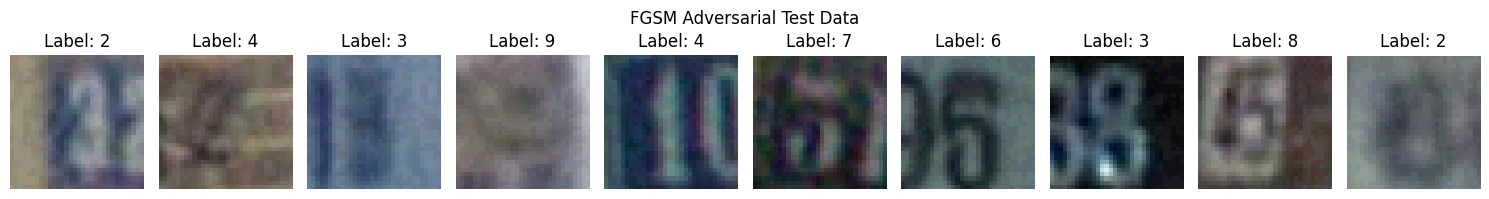

In [12]:
from art.attacks.evasion import FastGradientMethod

fgsm = FastGradientMethod(base_classifier, eps=EPSILON_FGSM)

X_test_fgsm = fgsm.generate(X_test)
y_test_fgsm = np.argmax(base_classifier.predict(X_test_fgsm), axis=1)

show_example(X_test_fgsm[::-10], y_test_fgsm[::-10], title="FGSM Adversarial Test Data")


In [13]:
# Evaluate the ART classifier on test examples
fgsm_predictions = base_classifier.predict(X_test_fgsm)
fgsm_accuracy = np.mean(np.argmax(fgsm_predictions, axis=1) == y_test)
print("Accuracy on FGSM adversarial test examples: {}%".format(fgsm_accuracy * 100))

Accuracy on FGSM adversarial test examples: 25.42905873574246%


#### Black-box Attack
- Use surrogate model to generate adversarial examples
- Surrogate model use pre-trained resnet18 model

In [14]:
# Define a CNN model using PyTorch
class SurrogateClassifier(nn.Module):
    def __init__(self):
        super(SurrogateClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.fc15 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x): 
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x))) 
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc15(x))
        x = self.fc2(x)
        return x
 

In [15]:
# Query result from base classifier to use as surrogate model train data.
y_train_base_predict = np.argmax(base_classifier.predict(X_train), axis=1)

# Train surrogate model 
surr_model = SurrogateClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(surr_model.parameters(), lr=learning_rate)
surrogate_classifier = PyTorchClassifier(
    model=surr_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device,
)

surrogate_classifier.fit(X_train, y_train_base_predict, 
                    batch_size=batch_size, 
                    nb_epochs=num_epochs,
                    verbose=True)


Epochs: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


In [16]:
# Evaluate the ART classifier on test examples
surr_predictions = surrogate_classifier.predict(X_test)
surr_accuracy = np.mean(np.argmax(surr_predictions, axis=1) == y_test) 
print("Accuracy on surrogate model test examples: {}%".format(surr_accuracy * 100))

Accuracy on surrogate model test examples: 86.25413068969193%


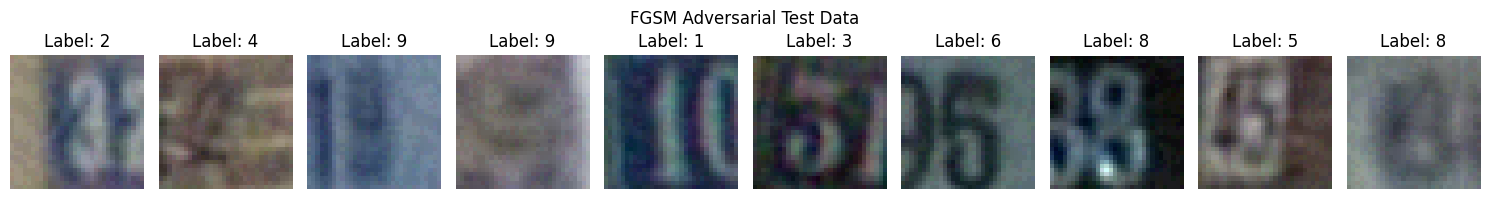

In [17]:
fgsm_surr = FastGradientMethod(surrogate_classifier, eps=EPSILON_FGSM, eps_step=0.01)

X_test_fgsm_surr = fgsm_surr.generate(X_test)
y_test_fgsm_surr = np.argmax(base_classifier.predict(X_test_fgsm_surr), axis=1)

show_example(X_test_fgsm_surr[::-10], y_test_fgsm_surr[::-10], title="FGSM Adversarial Test Data")


In [18]:
# Evaluate the ART classifier on test examples
fgsm_surr_predictions = base_classifier.predict(X_test_fgsm_surr)
fgsm_surr_accuracy = np.mean(np.argmax(fgsm_surr_predictions, axis=1) == y_test)
print("Accuracy on FGSM adversarial test examples: {}%".format(fgsm_surr_accuracy * 100))

Accuracy on FGSM adversarial test examples: 60.24944035817077%


#### 9.	Attack Impact Analysis
- Quantify robustness drop using:
  - Adversarial success rate
  - Confidence score distributions
  - Per-class vulnerability analysis


White box ASR : 80.40%
Black box ASR : 36.73%


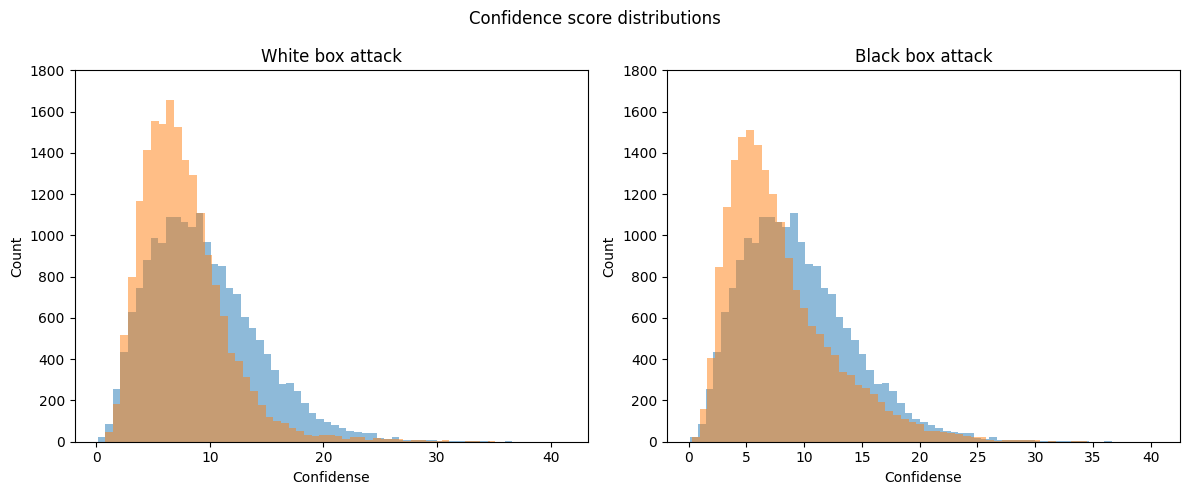

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
 
ax[0].hist(np.max(base_predition, axis=1), bins=60, alpha=0.5, label="Clean")
ax[0].hist(np.max(fgsm_predictions, axis=1), bins=60, alpha=0.5, label="Adversarial")
ax[0].set_xlabel("Confidense")
ax[0].set_ylabel("Count")
ax[0].set_ylim([0, 1800])
ax[0].set_title("White box attack")

ax[1].hist(np.max(base_predition, axis=1), bins=60, alpha=0.5, label="Clean")
ax[1].hist(np.max(fgsm_surr_predictions, axis=1), bins=60, alpha=0.5, label="Adversarial")
ax[1].set_xlabel("Confidense")
ax[1].set_ylabel("Count")
ax[1].set_ylim([0, 1800])
ax[1].set_title("Black box attack")

fig.suptitle("Confidence score distributions")
fig.tight_layout()
plt.plot()

# Adversarial Success Rate
white_box_asr = np.mean(np.argmax(fgsm_predictions, axis=1) != np.argmax(base_predition, axis=1))
black_box_asr = np.mean(np.argmax(fgsm_surr_predictions, axis=1) != np.argmax(base_predition, axis=1))

print("White box ASR : {:.2%}".format(white_box_asr))
print("Black box ASR : {:.2%}".format(black_box_asr))


[]

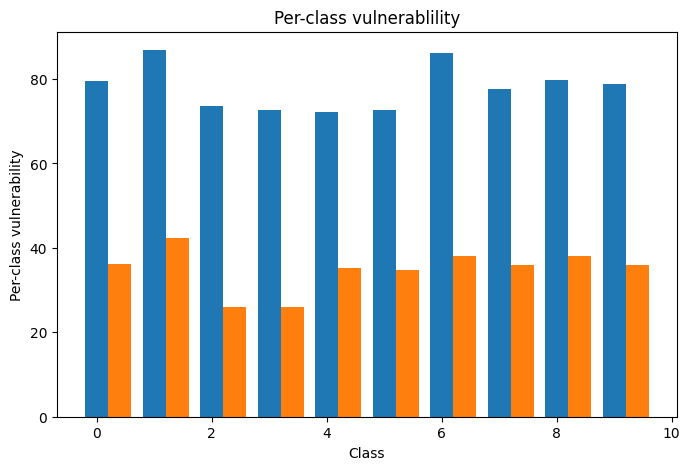

In [20]:
correct_predict = {}
success_white_attack = {}
success_black_attack = {}

for i in range(len(X_test)):
    base_pred = np.argmax(base_predition[i])
    adv_pred = np.argmax(fgsm_predictions[i])
    adv_sur_pred = np.argmax(fgsm_surr_predictions[i])
    if y_test[i] == base_pred:
        correct_predict[y_test[i]] = correct_predict.get(y_test[i], 0) + 1
        if adv_pred != base_pred:
            success_white_attack[y_test[i]] = success_white_attack.get(y_test[i], 0) + 1
        if adv_sur_pred != base_pred: 
            success_black_attack[y_test[i]] = success_black_attack.get(y_test[i], 0) + 1

white_box_vulnerability = {cls: (success_white_attack[cls] / correct_predict[cls] * 100) for cls in correct_predict.keys()}
black_box_vulnerability = {cls: (success_black_attack[cls] / correct_predict[cls] * 100) for cls in correct_predict.keys()}

x = np.arange(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, white_box_vulnerability.values(), width=0.4)
ax.bar(x + 0.4, black_box_vulnerability.values(), width=0.4)
ax.set_xlabel("Class")
ax.set_ylabel("Per-class vulnerability")
plt.title("Per-class vulnerablility")
plt.plot()

### Phase 5: Comprehensive Evaluation
#### 10.	Cross-Attack Susceptibility
- Test poisoned model against unseen attack vectors
- Analyze transferability between attack methods


In [21]:
backdoor_fgsm_prediction = poisoned_classifier.predict(X_test_fgsm)
backdoor_fgsm_accuracy = np.mean(np.argmax(backdoor_fgsm_prediction, axis=1) == y_test) 
print("Accuracy on FGSM adversarial(Whitebox) on Backdoor Model test examples: {}%".format(backdoor_fgsm_accuracy * 100))

backdoor_fgsm_surr_prediction = poisoned_classifier.predict(X_test_fgsm_surr)
backdoor_fgsm_surr_accuracy = np.mean(np.argmax(backdoor_fgsm_surr_prediction, axis=1) == y_test)  
print("Accuracy on FGSM adversarial(Blackbox) on Backdoor Model test examples: {}%".format(backdoor_fgsm_surr_accuracy * 100))

Accuracy on FGSM adversarial(Whitebox) on Backdoor Model test examples: 55.233983583839674%
Accuracy on FGSM adversarial(Blackbox) on Backdoor Model test examples: 60.90502078669652%


#### 11.	Vulnerability Report
- Create visualization: Security Curve for accuracy with both perturbations number and number of poisoned samples.
- Document failure modes and high-risk decision boundaries


# Part 2:  Defending Against Data Poisoning and Adversarial Attacks in Machine Learning

## Part 2 Phases:
### Phase 1: Poisoning Defense Implementation
#### 1.	Choose one Data Sanitization Techniques for example: 
- Implement anomaly detection (Isolation Forest/MAD)
- Apply spectral signature analysis for poisoned sample removal

In [22]:
from art.defences.detector.poison import SpectralSignatureDefense 
# Initialize Spectral Signature
ss_defense = SpectralSignatureDefense(classifier=base_classifier,
                                      x_train=X_train_poisoned,
                                      y_train=y_train_poisoned,
                                      expected_pp_poison=0.15,
                                      eps_multiplier=1.5,) 

report, is_clean_list = ss_defense.detect_poison()  

In [23]:
# Get clean dataset using the spectral signature defense
# Extract indices of clean samples from is_clean_list
clean_indices = [i for i, is_clean in enumerate(is_clean_list) if is_clean == 1]

# Filter the dataset to keep only clean samples
X_clean = X_train_poisoned[clean_indices]
y_clean = y_train_poisoned[clean_indices] 

sanitized_classifier = base_classifier.clone_for_refitting()
sanitized_classifier.fit(X_clean, y_clean, 
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)

Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


In [24]:
clean_prediction = sanitized_classifier.predict(X_test)
clean_accuracy = np.mean(np.argmax(clean_prediction, axis=1) == y_test)
print("Accuracy on dropout model test examples: {}%".format(clean_accuracy * 100)) 

Accuracy on dropout model test examples: 87.61326084639164%


Accuracy on dropout model on poisoned test examples: 99.53096684788402%


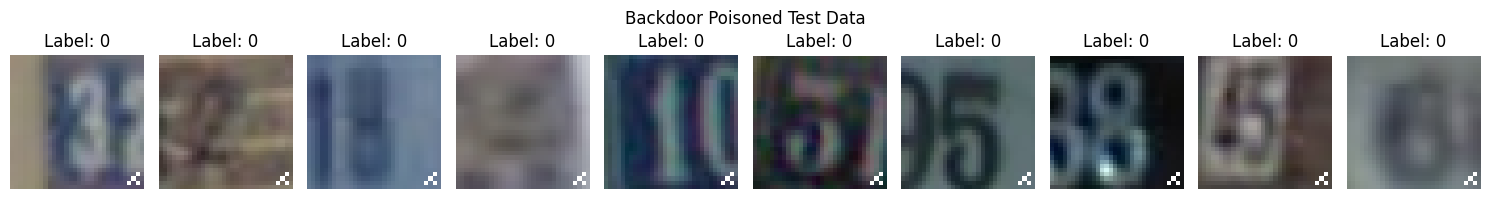

In [25]:
clean_poison_prediction = sanitized_classifier.predict(X_test_poisoned)
clean_poison_accuracy = np.mean(np.argmax(clean_poison_prediction, axis=1) == y_test_poisoned) 
print("Accuracy on dropout model on poisoned test examples: {}%".format(clean_poison_accuracy * 100))

show_example(X_test_poisoned[::-10], y_test_poisoned[::-10], title="Backdoor Poisoned Test Data")

#### 2.	And one method of Robust Training Methods for example:
- Integrate regularization (Dropout/Weight Clipping)
- Explore differentially private training


In [26]:
# Define a CNN model using PyTorch
class DropoutClassifier(nn.Module):
    def __init__(self):
        super(DropoutClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.drop2d = nn.Dropout2d(p=0.3)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Reshape input from (n_samples, 3072) to (n_samples, 3, 32, 32)
        # x = x.view(-1, 3, 32, 32)
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.drop2d(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.drop2d(x)
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
 

In [27]:
dropout_model = DropoutClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropout_model.parameters(), lr=learning_rate)

dropout_classifier = PyTorchClassifier(
    model=dropout_model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,    
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device,
)

dropout_classifier.fit(X_train_poisoned, y_train_poisoned, 
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)


Epochs: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


In [28]:
dropout_prediction = dropout_classifier.predict(X_test)
dropout_accuracy = np.mean(np.argmax(dropout_prediction, axis=1) == y_test)  
print("Accuracy on dropout model test examples: {}%".format(dropout_accuracy * 100)) 

Accuracy on dropout model test examples: 88.48203816224283%


Accuracy on dropout model on poisoned test examples: 99.37106918238993%


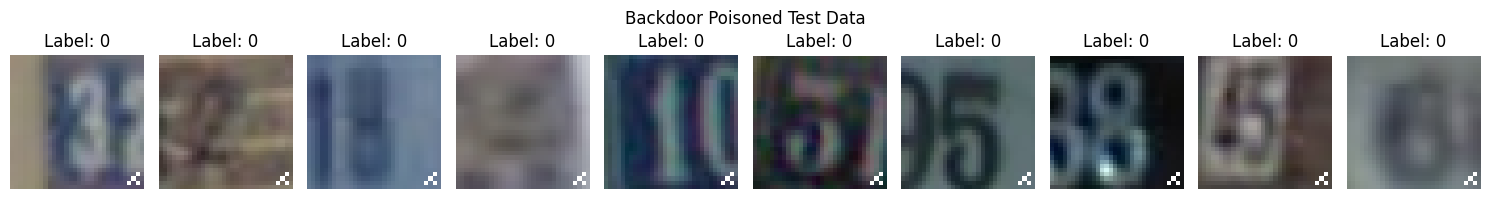

In [29]:
backdoor_poison_prediction = dropout_classifier.predict(X_test_poisoned)
backdoor_poison_accuracy = np.mean(np.argmax(backdoor_poison_prediction, axis=1) == y_test_poisoned)  
print("Accuracy on dropout model on poisoned test examples: {}%".format(backdoor_poison_accuracy * 100))

show_example(X_test_poisoned[::-10], y_test_poisoned[::-10], title="Backdoor Poisoned Test Data")

### Phase 2: Adversarial Defense Strategies
#### 3.	Input Preprocessing Defenses
- Test randomized smoothing techniques

In [30]:
from art.estimators.certification.randomized_smoothing import PyTorchRandomizedSmoothing

smoothing_model = Classifier() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(smoothing_model.parameters(), lr=learning_rate)

# Initialize the randomized smoothing wrapper with your PyTorch model
smoothing_classifier = PyTorchRandomizedSmoothing(
    model=smoothing_model,
    loss=criterion,
    input_shape=(3, 32, 32),
    nb_classes=10,
    optimizer=optimizer, 
    channels_first=True,  
    clip_values=(0, 1),  
    sample_size=32, 
    scale=0.1,  
    alpha=0.001  
)

In [31]:
smoothing_classifier.fit(X_train, y_train,
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [32]:
rs_prediction = smoothing_classifier.predict(X_test_fgsm)
rs_accuracy = np.mean(np.argmax(rs_prediction, axis=1) == y_test) 
print("Accuracy on smoothing model test examples: {}%".format(rs_accuracy * 100)) 

Accuracy on smoothing model test examples: 55.71367658032192%


In [33]:
rs_surr_prediction = smoothing_classifier.predict(X_test_fgsm_surr)
rs_surr_accuracy = np.mean(np.argmax(rs_surr_prediction, axis=1) == y_test)  
print("Accuracy on smoothing model test examples: {}%".format(rs_surr_accuracy * 100)) 

Accuracy on smoothing model test examples: 62.54663681910244%


In [34]:
# Certify robustness for input samples
certified_predictions, certified_radii = smoothing_classifier.certify(
    x=X_test_fgsm[0:20],
    n=1000,  # Number of samples for certification
    batch_size=32  # Batch size for processing
)

print(f"Certified prediction: {certified_predictions}")
print(f"Certified radius: {certified_radii}")
print(y_test[0:20])

Certified prediction: [ 6  8 -1  7  7  8 -1  6  4  7  2  5  9  2  4  9  5  7  4  2]
Certified radius: [0.21776912 0.22842918 0.         0.13609296 0.24632626 0.05405318
 0.         0.04258165 0.14151036 0.09233643 0.17943761 0.24632626
 0.01155937 0.00117551 0.16771905 0.23576506 0.24632626 0.1439862
 0.24632626 0.15612083]
[6 8 4 3 7 8 8 8 4 7 2 5 1 2 4 9 5 7 4 7]


#### 4.	Model Hardening
- Apply adversarial training with PGD examples
- Explore certified robustness methods (IBP/RS-Certify)


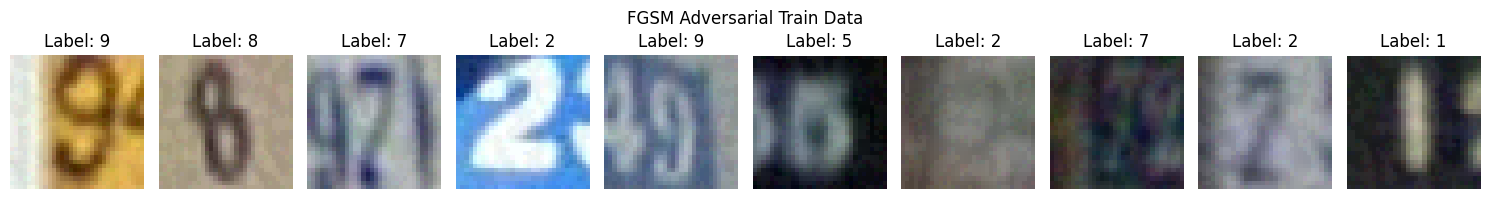

Epochs: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


In [35]:
fgsm = FastGradientMethod(base_classifier, eps=EPSILON_FGSM)

training_budget = int(0.15 * len(X_train))

train_fgsm = fgsm.generate(X_train[:training_budget]) 
X_train_adv = np.concatenate([train_fgsm, X_train[training_budget:]])

show_example(X_train_adv[:10], y_train[:10], title="FGSM Adversarial Train Data")

adv_trained_classifier = base_classifier.clone_for_refitting()
adv_trained_classifier.fit(X_train_adv, y_train,
               batch_size=batch_size, 
               nb_epochs=num_epochs,
               verbose=True)


In [36]:
adv_trn_prediction = adv_trained_classifier.predict(X_test_fgsm)
adv_trn_accuracy = np.mean(np.argmax(adv_trn_prediction, axis=1) == y_test) 
print("Accuracy on adversarial trained model with adversarial test example: {}%".format(adv_trn_accuracy * 100)) 

Accuracy on adversarial trained model with adversarial test example: 71.66080375226521%


In [38]:
adv_trn_surr_prediction = adv_trained_classifier.predict(X_test_fgsm_surr)
adv_trn_surr_accuracy = np.mean(np.argmax(adv_trn_surr_prediction, axis=1) == y_test) 
print("Accuracy on adversarial trained model with adversarial test example: {}%".format(adv_trn_surr_accuracy * 100)) 

Accuracy on adversarial trained model with adversarial test example: 74.52297196460933%


### Phase 3: Defense Evaluation
#### 5.	Quantitative Analysis
- Compare metrics before/after defenses:
  - Clean data accuracy preservation
  - Attack success rate reduction
  - Computational overhead

[]

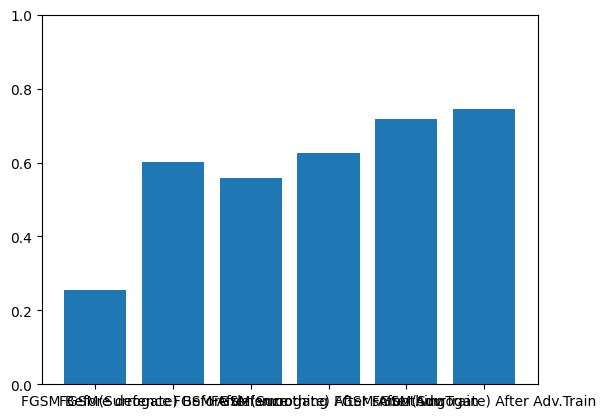

In [48]:
accuracy_matrix = {
    "FGSM Before defence": fgsm_accuracy,
    "FGSM(Surrogate) Before defence": fgsm_surr_accuracy,
    "FGSM After smoothing": rs_accuracy,
    "FGSM(Surrogate) After smoothing": rs_surr_accuracy,
    "FGSM After Adv.Train": adv_trn_accuracy,
    "FGSM(Surrogate) After Adv.Train": adv_trn_surr_accuracy,
}


plt.bar(accuracy_matrix.keys(), accuracy_matrix.values())
plt.ylim([0,1]) 
plt.plot()


#### 6.	Qualitative Analysis
- Visualize decision boundary changes
- Conduct gradient sensitivity analysis


c:\Users\pwiwa\anaconda3\envs\security\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\pwiwa\anaconda3\envs\security\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePr

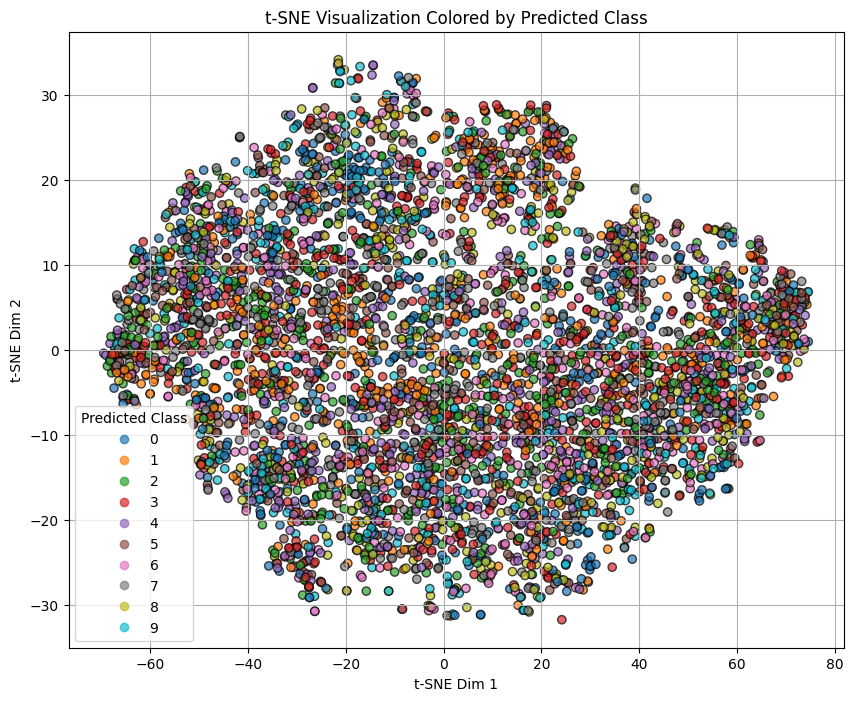

In [37]:
from sklearn.manifold import TSNE

# Step 2: Flatten images for t-SNE (t-SNE requires 2D input)
X_flat = X_train[0:5000].reshape((X_train[0:5000].shape[0], -1))

# Step 3: Apply t-SNE (you can adjust perplexity/speed tradeoff)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_flat)

# Step 4: Predict using ART classifier
preds = base_classifier.predict(X_train[0:5000])
Y_pred = np.argmax(preds, axis=1)

# Step 5: Plot with predicted labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=Y_pred, cmap='tab10', alpha=0.7, edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Predicted Class")
plt.title("t-SNE Visualization Colored by Predicted Class")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()

### Phase 4: Reporting & Advanced Exploration
#### 7.	Documentation Requirements
- Technical report (5-10 pages) covering:
  - Threat models & attack mechanics
  - Defense implementation details
  - Statistical evidence for robustness claims
